# Kernel

all step taken for advance lane detection.

In [1]:
# import necessary library
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import pickle
import math
print('done')

done


## Camera Undistortion

normally each camera will have some distortion that make some part of the image produced, have incorrect shape(sligh curve the main error is the silgh curve of the straight line near the egdes of the image).

The method that will be using here is following the [OpenCV tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)

To sumup the step to do the undistort are as followed;
*  took an image of cheesboard pattern in many position
*  find all the chessboard corners
*  calculate and calibrate the distortion value(using some library)
*  use this to undistort the image yay!

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

In [3]:
# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")
print(images)
print('num of all image: ' + str(len(images)))

['camera_cal\\calibration1.jpg', 'camera_cal\\calibration10.jpg', 'camera_cal\\calibration11.jpg', 'camera_cal\\calibration12.jpg', 'camera_cal\\calibration13.jpg', 'camera_cal\\calibration14.jpg', 'camera_cal\\calibration15.jpg', 'camera_cal\\calibration16.jpg', 'camera_cal\\calibration17.jpg', 'camera_cal\\calibration18.jpg', 'camera_cal\\calibration19.jpg', 'camera_cal\\calibration2.jpg', 'camera_cal\\calibration20.jpg', 'camera_cal\\calibration3.jpg', 'camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg', 'camera_cal\\calibration6.jpg', 'camera_cal\\calibration7.jpg', 'camera_cal\\calibration8.jpg', 'camera_cal\\calibration9.jpg']
num of all image: 20


In [4]:
# config subplot
num_img = len(images)
col = 4 # 4 image each row
row = math.ceil(num_img/col)

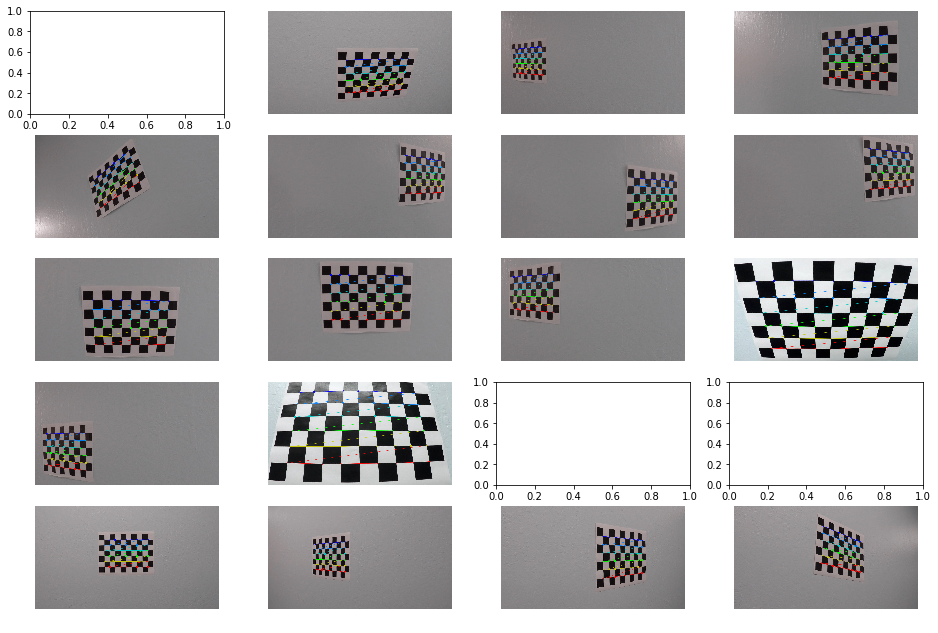

In [5]:
fig, axs = plt.subplots(row,col, figsize=(16, 11))
#fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)
        axs[i].axis('off')
        axs[i].imshow(img)


cv2.destroyAllWindows()

In [6]:
# calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

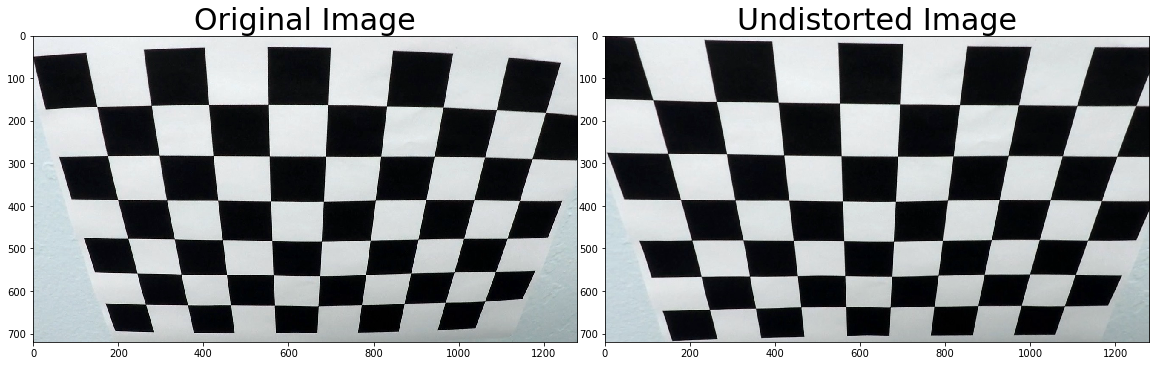

In [7]:
# test put our calibration parameter
test_img = cv2.imread(images[11])
dst = cv2.undistort(test_img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [8]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

## Testing with the road image

now let's try the calibration in some more realistic image

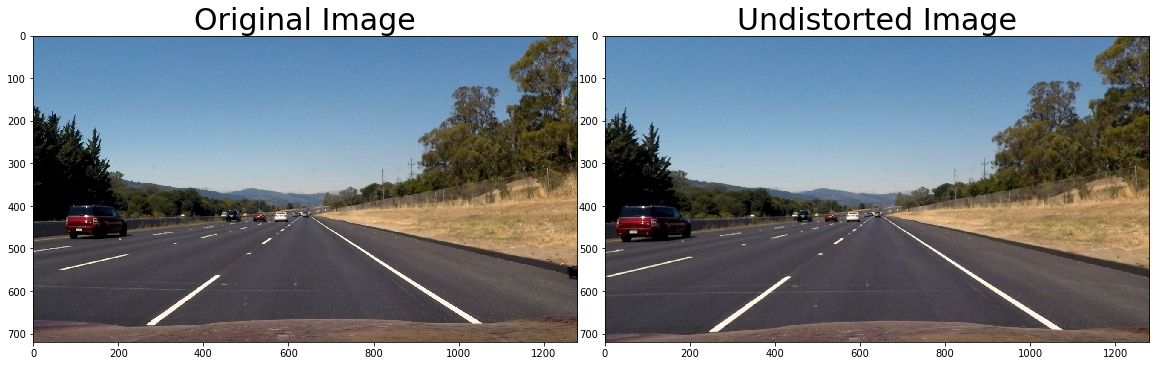

In [9]:
test_img = cv2.imread(glob.glob("test_images/*.jpg")[1])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
dist_pickle = pickle.load(open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

dst = cv2.undistort(test_img, mtx, dist, None, mtx)
undist_img = dst # for next step use
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [10]:
# wrapping our undistort work step into a fucntion for further used
def undistort_func(test_img, convColor=True, para="calibration.p"):
#     print('undistort_func')
    if convColor is True:
        print('COLOR_BGR2RGB')
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    dist_pickle = pickle.load(open(para, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    
    return undist_img


## Perspective transform

Next, what we want to do is covert our image from front view into bird's eye view.
Why do we want to do that? well to remove the persective effect on our image.
the figure above is a great example. Despite the line being a straight line, it appear as it is a Diagonal line toward the center. The line near the camera be wider than the one further away. 
this can be remove when we transform the image into bird's eyeview where everypart of the image have similar distance.

how we gonna do so? well similar to undistortion we select part of the image where we know it is a strait line and mapping it into the output image.

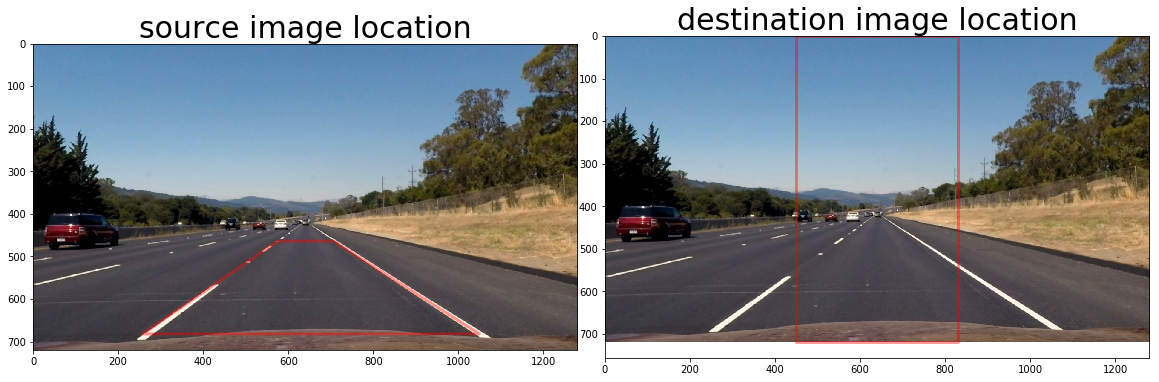

In [11]:
# get the image shape
h,w = undist_img.shape[:2]

# define sources point and destionation that it will mapping to
src_pts = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

dst_pts = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

# Visualize the point location
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_img)
x = [src_pts[0][0],src_pts[2][0],src_pts[3][0],src_pts[1][0],src_pts[0][0]]
y = [src_pts[0][1],src_pts[2][1],src_pts[3][1],src_pts[1][1],src_pts[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('source image location', fontsize=30)
ax2.imshow(undist_img)
x = [dst_pts[0][0],dst_pts[2][0],dst_pts[3][0],dst_pts[1][0],dst_pts[0][0]]
y = [dst_pts[0][1],dst_pts[2][1],dst_pts[3][1],dst_pts[1][1],dst_pts[0][1]]
ax2.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.set_title('destination image location', fontsize=30)

In [12]:
# see like the coordination choosed is a good choice so, let's use these value

In [13]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

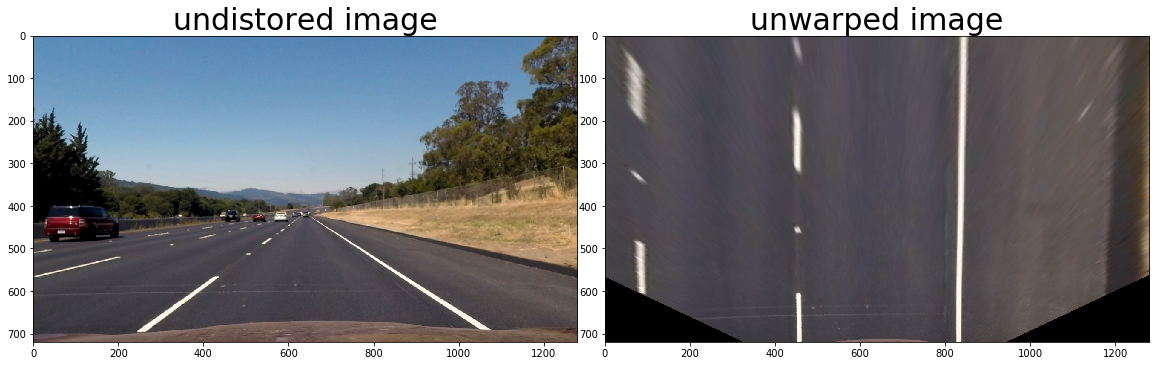

In [14]:
unwarp_img, M, Minv = unwarp(undist_img,src_pts,dst_pts)
# Visualize the point location
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_img)
ax1.set_title('undistored image', fontsize=30)
ax2.imshow(unwarp_img)
ax2.set_title('unwarped image', fontsize=30)

## Finding Thresholded Binary Image
fist let's try to see image will look like in many methods
In this function it will conv image into gradient, RGB, HSV, LAB
that concat it together. This way we can observe how each component look like compare to each other.
the way it concat is as follow;

In [38]:

def convImageToAll(src_img):
    undist_img = undistort_func(src_img,convColor=False)
    unwarp_img, M, Minv = unwarp(undist_img,src_pts,dst_pts)
    
    firstRow = np.concatenate((src_img, undist_img), axis=1)
    firstRow = np.concatenate((firstRow, unwarp_img), axis=1)
    
    # from RGB color space
    rgb_r_img = cv2.cvtColor(unwarp_img[:,:,0],cv2.COLOR_GRAY2RGB)
    rgb_g_img = cv2.cvtColor(unwarp_img[:,:,1],cv2.COLOR_GRAY2RGB)
    rgb_b_img = cv2.cvtColor(unwarp_img[:,:,2],cv2.COLOR_GRAY2RGB)
    
    secondRow = np.concatenate((rgb_r_img, rgb_g_img), axis=1)
    secondRow = np.concatenate((secondRow, rgb_b_img), axis=1)
    
    # from HSV color space
    hsv_img = cv2.cvtColor(unwarp_img, cv2.COLOR_RGB2HLS)
    hsv_h_img = cv2.cvtColor(hsv_img[:,:,0],cv2.COLOR_GRAY2RGB)
    hsv_s_img = cv2.cvtColor(hsv_img[:,:,1],cv2.COLOR_GRAY2RGB)
    hsv_v_img = cv2.cvtColor(hsv_img[:,:,2],cv2.COLOR_GRAY2RGB)
    
    thirdRow = np.concatenate((hsv_h_img, hsv_s_img), axis=1)
    thirdRow = np.concatenate((thirdRow, hsv_v_img), axis=1)
    
    # from LAB color space
    lab_img = cv2.cvtColor(unwarp_img, cv2.COLOR_RGB2Lab)
    lab_l_img = cv2.cvtColor(lab_img[:,:,0],cv2.COLOR_GRAY2RGB)
    lab_a_img = cv2.cvtColor(lab_img[:,:,1],cv2.COLOR_GRAY2RGB)
    lab_b_img = cv2.cvtColor(lab_img[:,:,2],cv2.COLOR_GRAY2RGB)
    
    fourthRow = np.concatenate((lab_l_img, lab_a_img), axis=1)
    fourthRow = np.concatenate((fourthRow, lab_b_img), axis=1)
    
    all_img = np.concatenate((firstRow, secondRow), axis=0)
    all_img = np.concatenate((all_img, thirdRow), axis=0)
    all_img = np.concatenate((all_img, fourthRow), axis=0)
    
    return all_img

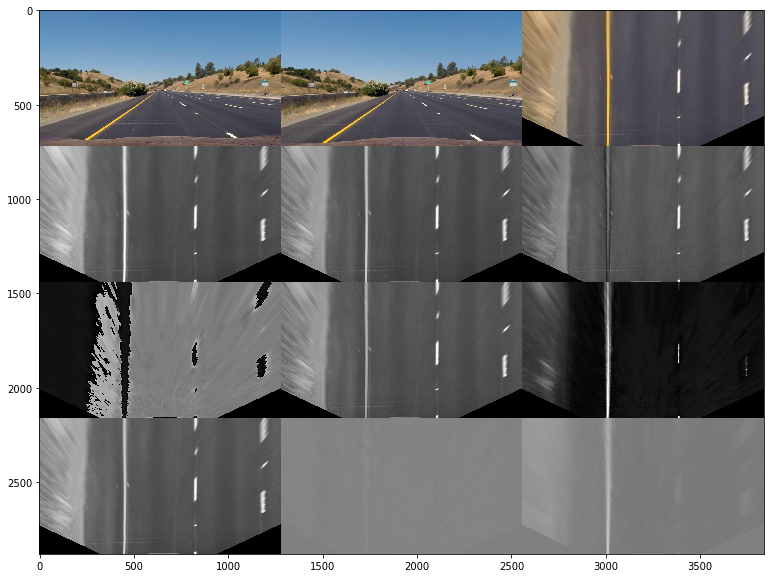

(2880, 3840, 3)


'../'

In [39]:
ret_img = convImageToAll(test_img)
plt.figure(figsize=(40,10))
plt.imshow(ret_img)
plt.show()
print(ret_img.shape)
'../'

In [17]:
# from just one picture doesn't give much information let's do it on video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [18]:
def process_image(imgFrm):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return convImageToAll(imgFrm)

In [40]:
videoFiles = glob.glob("*.mp4")
outputPath = 'output_videos/'
# for videoFile in videoFiles:
videoFile = videoFiles[1]
outputName = outputPath +  'allspace_' + videoFile
# print(outputName)
clip1 = VideoFileClip(videoFile)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(outputName, audio=False)

[MoviePy] >>>> Building video output_videos/allspace_harder_challenge_video.mp4
[MoviePy] Writing video output_videos/allspace_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [10:20<00:00,  1.61it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/allspace_harder_challenge_video.mp4 

Wall time: 10min 36s


## Implement Thresholding

after examine each color space component, it can be observe from the produced video that HSV: s component can detect the lane line pretty good except when there is a strong shadow.
On the other hand,in LAB: L component can detected the line on both normal and shadow situation. So, we will use both value to create out thresholding function.

### HSV: S component

In [31]:
def hls_s_threshold(img, thresh=(125, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return binary_output

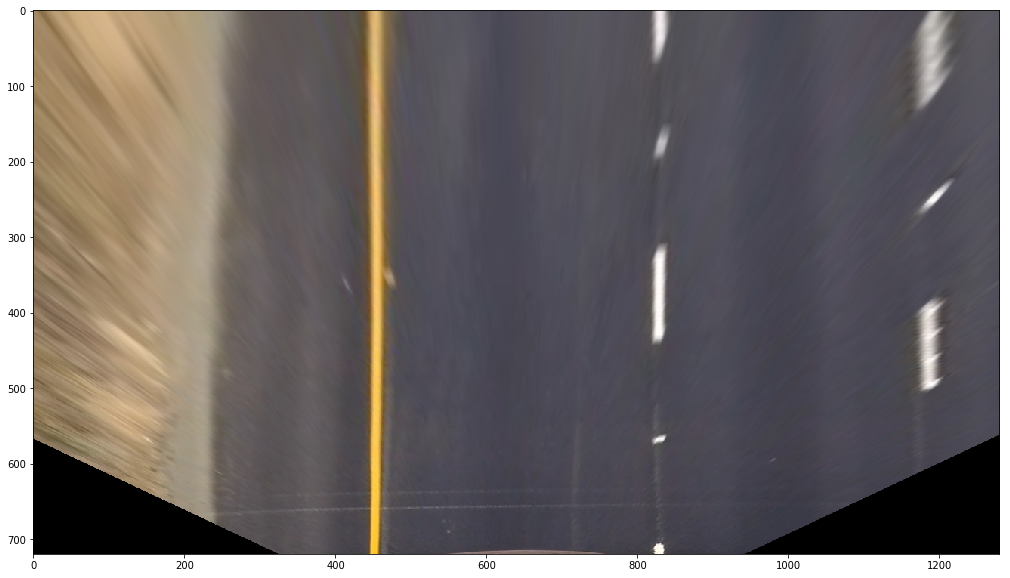

In [32]:
test_img = cv2.imread(glob.glob("test_images/*.jpg")[0])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undist_img = undistort_func(test_img,convColor=False)
unwarp_img, M, Minv = unwarp(undist_img,src_pts,dst_pts)
plt.figure(figsize=(40,10))
plt.imshow(unwarp_img)
plt.show()

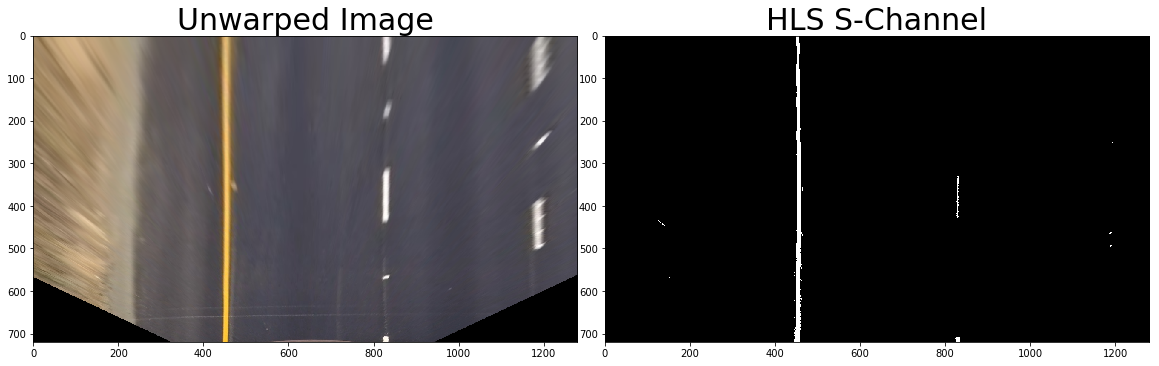

In [36]:
from ipywidgets import interact, interactive, fixed
def update(min_thresh, max_thresh):
    exampleImg_SThresh = hls_s_threshold(unwarp_img, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(unwarp_img)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_SThresh, cmap='gray')
    ax2.set_title('HLS S-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))


In [34]:
def hls_l_threshold(img, thresh=(220, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # Return a binary image of threshold result
    return binary_output


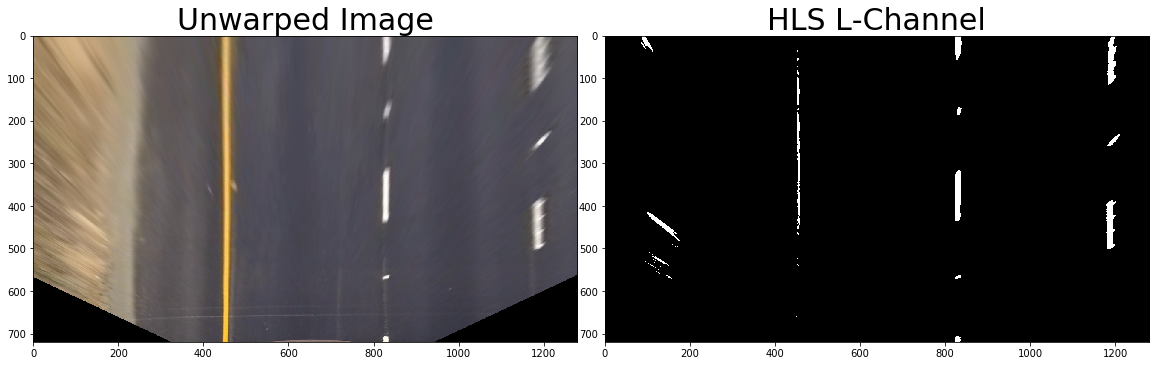

In [37]:
def update(min_thresh, max_thresh):
    exampleImg_SThresh = hls_l_threshold(unwarp_img, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(unwarp_img)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_SThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

In [41]:
# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


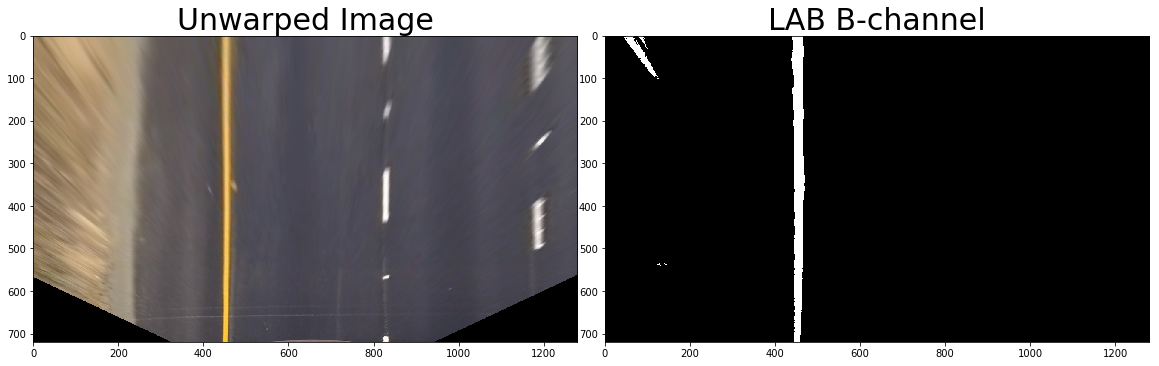

In [44]:
def update(min_b_thresh, max_b_thresh):
    exampleImg_LBThresh = lab_bthresh(unwarp_img, (min_b_thresh, max_b_thresh))
    # Visualize LAB B threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(unwarp_img)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=30)

interact(update,
         min_b_thresh=(0,255),
         max_b_thresh=(0,255))

print('...')

In [57]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# (hopefully)
def pipeline(img):
    # Undistort
    undist_img = undistort_func(img,convColor=False)
    
    
    # Perspective Transform
    unwarp_img, M, Minv = unwarp(undist_img,src_pts,dst_pts)

    # Sobel Absolute (using default parameters)
    #img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
#     img_SThresh = hls_s_threshold(unwarp_img)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_l_threshold(unwarp_img)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(unwarp_img)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1) ] = 1
    return combined, Minv
    


...


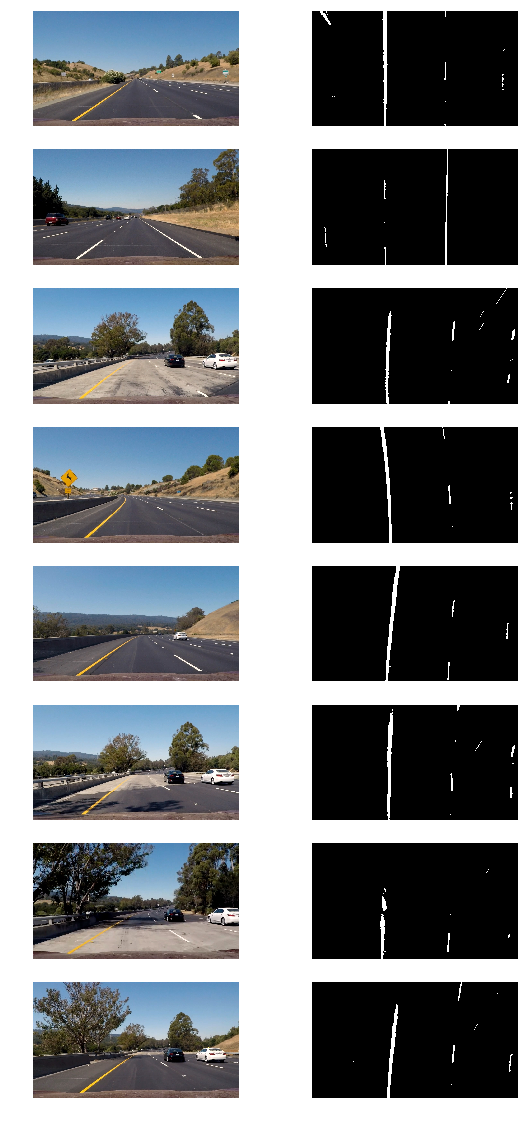

In [58]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

print('...')

# Sliding Window Polyfit


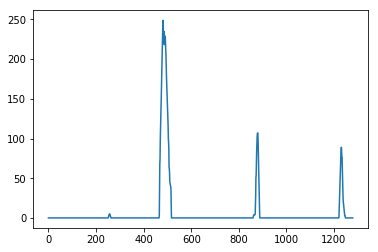

In [81]:
# Take a histogram of the bottom half of the image
histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
plt.plot(histogram)

the peak indicate the location of the lane line.
the right most is still not sure whether it is a line or noise however it best to stick with just line in current lane
so let's remove peak that is too far from the center

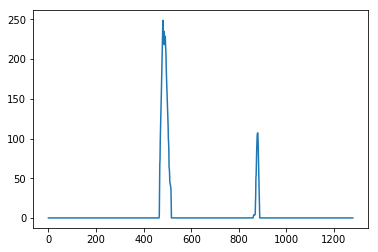

In [82]:
mid_pt = np.int(histogram.shape[0]//2)
quad_pt = np.int(mid_pt//2)
histogram[:quad_pt] = 0
histogram[mid_pt+quad_pt:] = 0
plt.plot(histogram)

In [83]:
# the left/right base was the max of the left/right half of the histogram
left_x_base = np.argmax(histogram[:mid_pt])
right_x_base = np.argmax(histogram[mid_pt:]) + mid_pt
print(leftx_base)
print(rightx_base)

481
879


In [84]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
    mid_pt = np.int(histogram.shape[0]//2)
    quad_pt = np.int(mid_pt//2)
    #remove too far to left and right side
    histogram[:quad_pt] = 0
    histogram[mid_pt+quad_pt:] = 0
    # the left/right base was the max of the left/right half of the histogram
    left_x_base = np.argmax(histogram[:mid_pt])
    right_x_base = np.argmax(histogram[mid_pt:]) + mid_pt
    
    
    ### windows parameter
    
    # Number of sliding windows
    nwindows = 10 
    # Height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    left_x_cur = left_x_base
    right_x_cur = right_x_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = left_x_cur - margin
        win_xleft_high = left_x_cur + margin
        win_xright_low = right_x_cur - margin
        win_xright_high = right_x_cur + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data


...


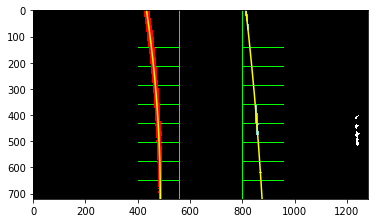

In [86]:
# visualize the result on example image
exampleImg = cv2.imread('./test_images/test2.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print('...')

In [87]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

...


...


Ellipsis

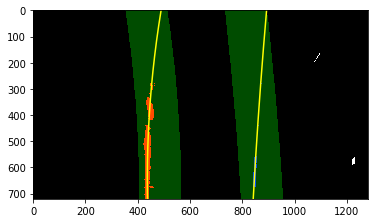

In [88]:
# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test5.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('...')
...

## Radius of Curvature and Distance from Lane Center Calculation

In [89]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

...


In [90]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 454.230667943 m, 1274.44473829 m
Distance from lane center for example: -0.400041700376 m


In [91]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('...')

...


...


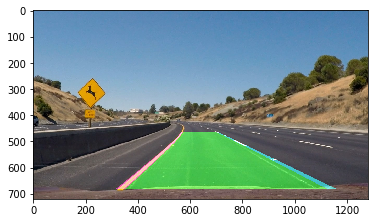

In [93]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)
print('...')

## Draw Curvature Radius and Distance from Center Data onto the Original Image


In [95]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


...


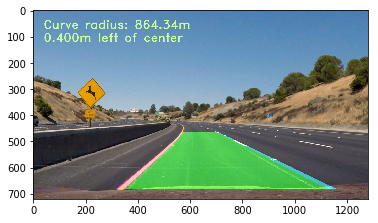

In [96]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)
print('...')

# Define a Line Class for Storing Data

In [97]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            

print('...')

...


# Define Complete Image Processing Pipeline

In [99]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out
print('...')

...


## Method for plotting a fit on a binary image - diagnostic purposes

In [101]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('...')

...


## Process Project Video

In [102]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:09<00:00,  6.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 11s
